In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

import string
import re

from sklearn.model_selection import train_test_split

from imageio import imread

from keras.applications import InceptionV3
from keras import Model

from keras.preprocessing import image
from keras.applications.inception_v3 import preprocess_input
from keras.models import Sequential

import os

import pickle

from sklearn.decomposition import PCA

from network_visualizer import NetworkVisualizer

/Users/khalilcherif/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Exploration of  feature extraction using  InceptionV3 model

Our goal is to be able to visualize the activations of neurons during the transform phase of an image to extract the its features using InceptionV3. 
Ultimately, but not reached for the moment, we would like to reduce the size of the neural network without compromising its ability to transfer the useful information about the image so that the transformation can be made musch faster

for the sake of this, we created a customized class NetworkVisualizer  which we will use throughout this notebook. The usage will be explained as we advance in our feature exploration.

Of course, this is still to be improved, we are only in our first day of development.

In [2]:
with open("train_imgs.pickle" , "rb") as file:
    unpickler = pickle.Unpickler(file)
    train_data = unpickler.load()

In [3]:
test_desc = train_data['133189853_811de6ab2a']['descriptions']
test_desc[0]

'startseq man wearing tuxedo shirt vest and bowtie is kissing another man wearing the same thing on the cheek endseq'

In [4]:
def get_data_of_concept(data , concept):
    
    # all the descriptions should already be preprocessed
    def filter_on(descs , keyword):
        for desc in descs:
            if keyword in desc:
                return True
        return False
    
    return [ value['features'] for key,value in train_data.items() if filter_on( value['descriptions'] , concept ) ]

In [5]:
concepts_to_try = [ 'cat' , 'dog' , 'car' , 'flower' , 'walk' ]

In [6]:
data = train_data
concepts_to_data = dict( [ ( concept , get_data_of_concept( data , concept ) ) for concept in concepts_to_try ] )

In [7]:
# Get the InceptionV3 model trained on imagenet data
model = InceptionV3(weights='imagenet')
# Remove the last layer (output softmax layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [8]:
some_cat_data = concepts_to_data['car'][:10]

In [9]:
nkviz = NetworkVisualizer( model = model_new )

In [10]:
nkviz.compute_statistics( some_cat_data , concepts = ['cat'] , policy = 'update' , layers_names=[layer.name for layer in model_new.layers if 'activation' in layer.name][-2:])

			********** Statistics for layer activation_94**********

Number of 'unused' neurons (activation == 0) : 3270 out of 12288
percentage of 'unused' neurons : 26.611328125 %


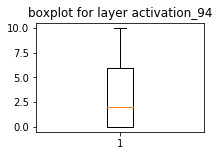





			********** Statistics for layer activation_86**********

Number of 'unused' neurons (activation == 0) : 3030 out of 20480
percentage of 'unused' neurons : 14.794921875 %


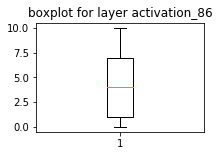

In [11]:
nkviz.print_statistics()

In [12]:
len( nkviz.filter_activation( 'activation_86' , variance_threshold = 0 , min_max_scaler = True ) )

17450

In [13]:
len( nkviz.filter_activation( 'activation_86' , variance_threshold = 0.1 , min_max_scaler = True ) )

13966

In [14]:
pca = PCA(n_components=10000)

In [15]:
nkviz.transform_activation( 'activation_86' , transformer=pca ).shape

(10, 10)

### Let's try to analyze how our activation layers behave when dealing with only cats and dogs images

In [16]:
cat_data = [  np.expand_dims( np.array( image.load_img(f"dataset/training_set/cats/{img_name}", target_size=(299, 299)) ) , axis=0 )  for img_name in os.listdir("dataset/training_set/cats/")[:100] ]
dog_data = [  np.expand_dims( np.array( image.load_img(f"dataset/training_set/dogs/{img_name}", target_size=(299, 299)) ) , axis=0 )  for img_name in os.listdir("dataset/training_set/dogs/")[:100] ]


In [17]:
#concepts_to_data = {'dog' : dog_data , 'cat' : cat_data}

Small modifications should be made, but in the future the class can show statistics for every concept independantly from the others, so different instance for different combinations of concept would no longer be required

In [18]:
cat_nkviz = NetworkVisualizer(model_new)
dog_nkviz = NetworkVisualizer(model_new)

In [36]:
cat_dog_nkviz = NetworkVisualizer(model_new)

In [19]:
def batch_generator(data, n_batch=10):
    
    ret = []
    
    for d in data:
        if len(ret) == n_batch:
            yield ret
            ret = []
        ret.append(d)
        
    yield ret

In [20]:
layers_to_monitor = [layer.name for layer in model_new.layers if 'activation' in layer.name][-2:]
layers_to_monitor

['activation_86', 'activation_94']

In [21]:
cat_gen = batch_generator(cat_data)
dog_gen = batch_generator(dog_data)

			********** Statistics for layer activation_94**********

Number of 'unused' neurons (activation == 0) : 4384 out of 12288
percentage of 'unused' neurons : 35.67708333333333 %


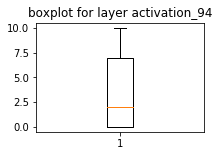





			********** Statistics for layer activation_86**********

Number of 'unused' neurons (activation == 0) : 4858 out of 20480
percentage of 'unused' neurons : 23.720703125 %


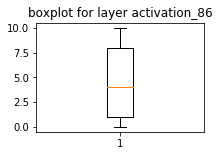

In [22]:
cat_nkviz.compute_statistics( next(cat_gen) , concepts=['cat'] , policy='update' , layers_names=layers_to_monitor)
cat_nkviz.print_statistics()

			********** Statistics for layer activation_94**********

Number of 'unused' neurons (activation == 0) : 3390 out of 12288
percentage of 'unused' neurons : 27.587890625 %


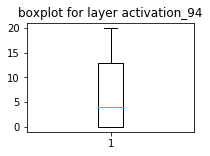





			********** Statistics for layer activation_86**********

Number of 'unused' neurons (activation == 0) : 3347 out of 20480
percentage of 'unused' neurons : 16.3427734375 %


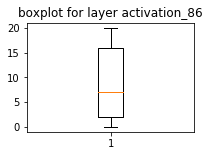

In [23]:
cat_nkviz.compute_statistics( next(cat_gen) , concepts=['cat'] , policy='update' , layers_names=layers_to_monitor)
cat_nkviz.print_statistics()

			********** Statistics for layer activation_94**********

Number of 'unused' neurons (activation == 0) : 2731 out of 12288
percentage of 'unused' neurons : 22.224934895833336 %


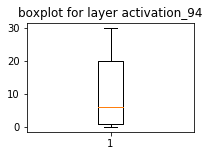





			********** Statistics for layer activation_86**********

Number of 'unused' neurons (activation == 0) : 2468 out of 20480
percentage of 'unused' neurons : 12.05078125 %


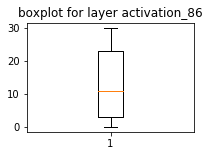

In [24]:
cat_nkviz.compute_statistics( next(cat_gen) , concepts=['cat'] , policy='update' , layers_names=layers_to_monitor)
cat_nkviz.print_statistics()

			********** Statistics for layer activation_94**********

Number of 'unused' neurons (activation == 0) : 2462 out of 12288
percentage of 'unused' neurons : 20.035807291666664 %


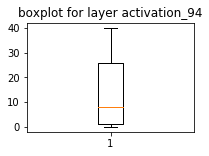





			********** Statistics for layer activation_86**********

Number of 'unused' neurons (activation == 0) : 2117 out of 20480
percentage of 'unused' neurons : 10.3369140625 %


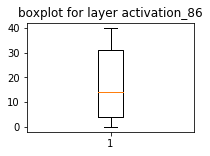

In [25]:
cat_nkviz.compute_statistics( next(cat_gen) , concepts=['cat'] , policy='update' , layers_names=layers_to_monitor)
cat_nkviz.print_statistics()

			********** Statistics for layer activation_94**********

Number of 'unused' neurons (activation == 0) : 2201 out of 12288
percentage of 'unused' neurons : 17.911783854166664 %


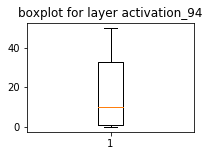





			********** Statistics for layer activation_86**********

Number of 'unused' neurons (activation == 0) : 1815 out of 20480
percentage of 'unused' neurons : 8.8623046875 %


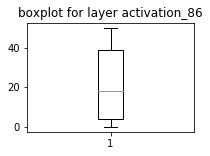

In [26]:
cat_nkviz.compute_statistics( next(cat_gen) , concepts=['cat'] , policy='update' , layers_names=layers_to_monitor)
cat_nkviz.print_statistics()

			********** Statistics for layer activation_94**********

Number of 'unused' neurons (activation == 0) : 2109 out of 12288
percentage of 'unused' neurons : 17.1630859375 %


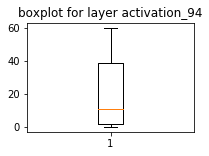





			********** Statistics for layer activation_86**********

Number of 'unused' neurons (activation == 0) : 1634 out of 20480
percentage of 'unused' neurons : 7.978515625 %


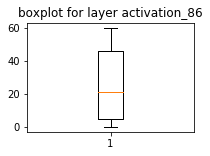

In [27]:
cat_nkviz.compute_statistics( next(cat_gen) , concepts=['cat'] , policy='update' , layers_names=layers_to_monitor)
cat_nkviz.print_statistics()

It seems like we converged towards the set of neurons that we will use to extract the features of cat images
Let's now check if this set of neurons is close to the set of neurons when the dataset is composed of cats and dogs.
It should not be the same, but we expect them to be very close since the features to extract from a cat image and a dog image should be quite similar

Let's now visualize how this converges for both concepts (cat and dog) for the same layers as before

In [37]:
# We divided by 2 n_batch so that the same amout of data is fed to the class at each call
cat_gen = batch_generator(cat_data , n_batch=5)
dog_gen = batch_generator(dog_data , n_batch=5)

			********** Statistics for layer activation_94**********

Number of 'unused' neurons (activation == 0) : 4060 out of 12288
percentage of 'unused' neurons : 33.04036458333333 %


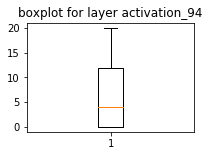





			********** Statistics for layer activation_86**********

Number of 'unused' neurons (activation == 0) : 4226 out of 20480
percentage of 'unused' neurons : 20.634765625 %


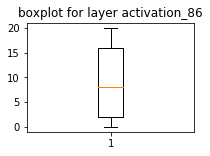

In [38]:
cat_dog_nkviz.compute_statistics( next(cat_gen) + next(dog_gen) , concepts=['cat' , 'dog'] , policy='update' , layers_names=layers_to_monitor)
cat_dog_nkviz.print_statistics()

			********** Statistics for layer activation_94**********

Number of 'unused' neurons (activation == 0) : 3054 out of 12288
percentage of 'unused' neurons : 24.853515625 %


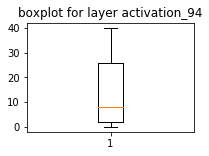





			********** Statistics for layer activation_86**********

Number of 'unused' neurons (activation == 0) : 2919 out of 20480
percentage of 'unused' neurons : 14.252929687499998 %


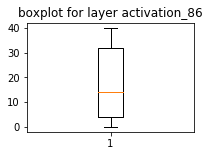

In [39]:
cat_dog_nkviz.compute_statistics( next(cat_gen) + next(dog_gen) , concepts=['cat' , 'dog'] , policy='update' , layers_names=layers_to_monitor)
cat_dog_nkviz.print_statistics()

			********** Statistics for layer activation_94**********

Number of 'unused' neurons (activation == 0) : 2686 out of 12288
percentage of 'unused' neurons : 21.858723958333336 %


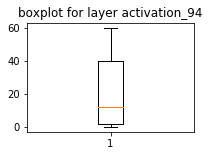





			********** Statistics for layer activation_86**********

Number of 'unused' neurons (activation == 0) : 2345 out of 20480
percentage of 'unused' neurons : 11.4501953125 %


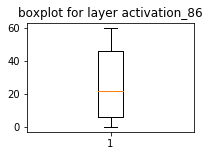

In [40]:
cat_dog_nkviz.compute_statistics( next(cat_gen) + next(dog_gen) , concepts=['cat' , 'dog'] , policy='update' , layers_names=layers_to_monitor)
cat_dog_nkviz.print_statistics()

			********** Statistics for layer activation_94**********

Number of 'unused' neurons (activation == 0) : 2457 out of 12288
percentage of 'unused' neurons : 19.9951171875 %


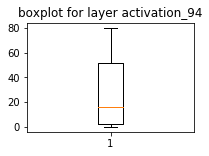





			********** Statistics for layer activation_86**********

Number of 'unused' neurons (activation == 0) : 1987 out of 20480
percentage of 'unused' neurons : 9.7021484375 %


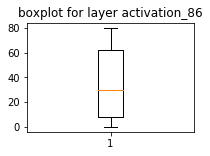

In [41]:
cat_dog_nkviz.compute_statistics( next(cat_gen) + next(dog_gen) , concepts=['cat' , 'dog'] , policy='update' , layers_names=layers_to_monitor)
cat_dog_nkviz.print_statistics()

			********** Statistics for layer activation_94**********

Number of 'unused' neurons (activation == 0) : 2253 out of 12288
percentage of 'unused' neurons : 18.3349609375 %


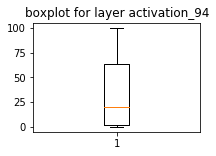





			********** Statistics for layer activation_86**********

Number of 'unused' neurons (activation == 0) : 1716 out of 20480
percentage of 'unused' neurons : 8.37890625 %


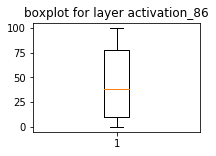

In [42]:
cat_dog_nkviz.compute_statistics( next(cat_gen) + next(dog_gen) , concepts=['cat' , 'dog'] , policy='update' , layers_names=layers_to_monitor)
cat_dog_nkviz.print_statistics()

			********** Statistics for layer activation_94**********

Number of 'unused' neurons (activation == 0) : 1916 out of 12288
percentage of 'unused' neurons : 15.592447916666666 %


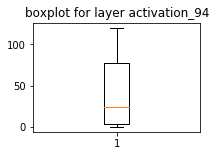





			********** Statistics for layer activation_86**********

Number of 'unused' neurons (activation == 0) : 1478 out of 20480
percentage of 'unused' neurons : 7.216796875000001 %


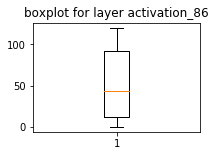

In [43]:
cat_dog_nkviz.compute_statistics( next(cat_gen) + next(dog_gen) , concepts=['cat' , 'dog'] , policy='update' , layers_names=layers_to_monitor)
cat_dog_nkviz.print_statistics()

In [48]:
cat_used_neurons = set( cat_nkviz.filter_activation( 'activation_86' , variance_threshold = 0 ) )
cat_dog_used_neurons = set( cat_dog_nkviz.filter_activation( 'activation_86' , variance_threshold = 0 ) )

union = cat_dog_used_neurons.union( cat_used_neurons )

print(f'number of cat used_neurons : {len(cat_used_neurons)}')
print(f'number of cat_dog used_neurons : {len(cat_dog_used_neurons)}')
print(f'number of cat and cat_dog used_neurons : {len(union)}')

number of cat used_neurons : 18846
number of cat_dog used_neurons : 19002
number of cat and cat_dog used_neurons : 19331


As we can see, they seem to activate the 'same' neurons, the restriction we used, variance == 0 is too difficult to be always met, if a neuron activates at least once during any predict phase, it will be added to the list of used neurons. A more studied filtering should be able to determine what are the most important neurons for the dataset we are dealing with.

The goal of this notebook, is to show that during transfer learning, many neurons can be 'dicarded', their value is always 0 during activation. We aim for the future to study better how to make a good filtering and thus maybe reduce the overall size of the neural network for the sake of our work. The model used, InceptionV3 is a huge neural network, transforming 8000 images took over than 4 hours (even on a high end laptop, but no GPU were used). So diminishig the size of the model and being able to transfer the important information from it is a task worth it to spend some time on it.